Step 1: Import Necessary Libraries

In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Load and Explore the Dataset

In [2]:
# Load datasets
df_naive = pd.read_csv("final_Naive.csv")
df_grid = pd.read_csv("Gridbased_yang.csv")

# Display basic information
print(df_naive.head())
print(df_grid.head())

                                     id       lon       lat        date  kph2   
0  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12966  26.33206  2022-09-01   0.0  \
1  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12937  26.33207  2022-09-01   0.0   
2  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12919  26.33209  2022-09-01   0.0   
3  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12911  26.33206  2022-09-01   0.0   
4  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12903  26.33202  2022-09-01   0.0   

    sog  Distance_miles    azimuth  Segment  trip_id  label  
0  36.4        0.000000  88.985217        0        0      0  
1  41.2        0.018003  89.169638        0        0      0  
2  42.0        0.011251  89.190649        0        0      0  
3  37.9        0.005375  91.503682        0        0      0  
4  34.3        0.005676  93.451285        0        0      0  
                                     id       lon       lat        date   
0  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12966  26.33206  2022-

Step 3: Select Drivers and Split Data

In [3]:
# Select 7 normal and 5 abnormal drivers at random
num_normal_drivers = 7
num_abnormal_drivers = 5

# Select drivers from the naive dataset (same IDs are present in both datasets)
selected_normal_drivers = np.random.choice(df_naive[df_naive['label'] == 0]['id'].unique(), num_normal_drivers, replace=False)
selected_abnormal_drivers = df_naive[df_naive['label'] == 1]['id'].unique()[:num_abnormal_drivers]

# Get data for selected drivers
selected_normal_data_naive = df_naive[df_naive['id'].isin(selected_normal_drivers)]
selected_abnormal_data_naive = df_naive[df_naive['id'].isin(selected_abnormal_drivers)]
selected_normal_data_grid = df_grid[df_grid['id'].isin(selected_normal_drivers)]
selected_abnormal_data_grid = df_grid[df_grid['id'].isin(selected_abnormal_drivers)]

# Combine selected data
selected_data_naive = pd.concat([selected_normal_data_naive, selected_abnormal_data_naive])
selected_data_grid = pd.concat([selected_normal_data_grid, selected_abnormal_data_grid])

# Split each selected driver's data into training (30%) and testing (70%) sets
def split_driver_data(driver_data, train_size=0.3):
    train_data_list = []
    test_data_list = []
    
    for driver_id, group in driver_data.groupby('id'):
        train_data, test_data = train_test_split(group, train_size=train_size, random_state=42)
        train_data_list.append(train_data)
        test_data_list.append(test_data)
    
    train_data = pd.concat(train_data_list)
    test_data = pd.concat(test_data_list)
    
    return train_data, test_data

# Split the selected data
train_data_naive, test_data_naive = split_driver_data(selected_data_naive)
train_data_grid, test_data_grid = split_driver_data(selected_data_grid)

# Ensure same drivers are selected in both datasets
train_data_grid = df_grid[df_grid['id'].isin(train_data_naive['id']) & df_grid['Segment'].isin(train_data_naive['Segment'])]
test_data_grid = df_grid[df_grid['id'].isin(test_data_naive['id']) & df_grid['Segment'].isin(test_data_naive['Segment'])]

print(f"Training data shape (Naive): {train_data_naive.shape}")
print(f"Testing data shape (Naive): {test_data_naive.shape}")
print(f"Training data shape (Grid): {train_data_grid.shape}")
print(f"Testing data shape (Grid): {test_data_grid.shape}")

Training data shape (Naive): (2426624, 11)
Testing data shape (Naive): (5662138, 11)
Training data shape (Grid): (8088155, 15)
Testing data shape (Grid): (8088708, 15)


Step 4: Preprocess the Data for 2D CNN and Simple NN

In [31]:
# Define feature columns
naive_feature_cols = ['lon', 'lat', 'kph2', 'sog', 'Distance_miles', 'azimuth']
grid_feature_cols = ['lon', 'lat', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y', 'aug180_grid_x', 'aug180_grid_y', 'aug270_grid_x', 'aug270_grid_y']

segment_length = 200

# Preprocess function for Naive features
def preprocess_naive_features(df, feature_cols, segment_length):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        if len(segment_flat) < segment_length * len(feature_cols):
            segment_flat = np.pad(segment_flat, (0, segment_length * len(feature_cols) - len(segment_flat)), 'constant')
        elif len(segment_flat) > segment_length * len(feature_cols):
            segment_flat = segment_flat[:segment_length * len(feature_cols)]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess function for Grid features
def preprocess_cnn_features(df, feature_cols, segment_length):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        if len(segment_flat) < segment_length * len(feature_cols):
            segment_flat = np.pad(segment_flat, (0, segment_length * len(feature_cols) - len(segment_flat)), 'constant')
        elif len(segment_flat) > segment_length * len(feature_cols):
            segment_flat = segment_flat[:segment_length * len(feature_cols)]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess Naive features for training
naive_segments_train, naive_labels_train = preprocess_naive_features(train_data_naive, naive_feature_cols, segment_length)
naive_segments_test, naive_labels_test = preprocess_naive_features(test_data_naive, naive_feature_cols, segment_length)

# Preprocess Grid features for training
grid_segments_train, _ = preprocess_cnn_features(train_data_grid, grid_feature_cols, segment_length)
grid_segments_test, _ = preprocess_cnn_features(test_data_grid, grid_feature_cols, segment_length)

# Impute and normalize Naive features
imputer_naive = SimpleImputer(strategy='mean')
naive_segments_train_imputed = imputer_naive.fit_transform(naive_segments_train)
naive_segments_test_imputed = imputer_naive.transform(naive_segments_test)

scaler_naive = StandardScaler()
naive_segments_train_scaled = scaler_naive.fit_transform(naive_segments_train_imputed)
naive_segments_test_scaled = scaler_naive.transform(naive_segments_test_imputed)

# Impute and normalize Grid features
imputer_grid = SimpleImputer(strategy='mean')
grid_segments_train_imputed = imputer_grid.fit_transform(grid_segments_train)
grid_segments_test_imputed = imputer_grid.transform(grid_segments_test)

scaler_grid = StandardScaler()
grid_segments_train_scaled = scaler_grid.fit_transform(grid_segments_train_imputed)
grid_segments_test_scaled = scaler_grid.transform(grid_segments_test_imputed)

# Reshape grid features for CNN (N, C, H, W)
grid_segments_train_scaled = grid_segments_train_scaled.reshape(-1, 1, segment_length, len(grid_feature_cols))
grid_segments_test_scaled = grid_segments_test_scaled.reshape(-1, 1, segment_length, len(grid_feature_cols))

# Convert to tensors
X_train_naive_tensor = torch.tensor(naive_segments_train_scaled, dtype=torch.float)
X_test_naive_tensor = torch.tensor(naive_segments_test_scaled, dtype=torch.float)
X_train_cnn_tensor = torch.tensor(grid_segments_train_scaled, dtype=torch.float)
X_test_cnn_tensor = torch.tensor(grid_segments_test_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(naive_labels_train, dtype=torch.long)
y_test_tensor = torch.tensor(naive_labels_test, dtype=torch.long)

# Check shapes
print(f"X_train_naive_tensor: {X_train_naive_tensor.shape}")
print(f"X_test_naive_tensor: {X_test_naive_tensor.shape}")
print(f"X_train_cnn_tensor: {X_train_cnn_tensor.shape}")
print(f"X_test_cnn_tensor: {X_test_cnn_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")
print(f"y_test_tensor: {y_test_tensor.shape}")

X_train_naive_tensor: torch.Size([101973, 1200])
X_test_naive_tensor: torch.Size([102123, 1200])
X_train_cnn_tensor: torch.Size([101973, 1, 200, 10])
X_test_cnn_tensor: torch.Size([102123, 1, 200, 10])
y_train_tensor: torch.Size([101973])
y_test_tensor: torch.Size([102123])


Step 4: Define and Train the Combined Model

In [32]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the combined model
class CombinedModel(nn.Module):
    def __init__(self, input_size_naive, input_size_cnn):
        super(CombinedModel, self).__init__()
        
        # Simple NN for Naive features
        self.fc1_naive = nn.Linear(input_size_naive, 128)
        self.fc2_naive = nn.Linear(128, 64)
        self.fc3_naive = nn.Linear(64, 32)
        
        # 2D CNN for Grid features
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        
        # Calculate the size of the flattened feature map after the convolution and pooling layers
        self.fc_input_size = 128 * (segment_length // 8) * (len(grid_feature_cols) // 8)
        
        self.fc1_cnn = nn.Linear(self.fc_input_size, 256)
        self.fc2_cnn = nn.Linear(256, 64)
        self.fc3_cnn = nn.Linear(64, 32)
        
        # Combined features
        self.fc_combined = nn.Linear(32 + 32, 2)  # 32 from NN and 32 from CNN
        
    def forward(self, x_naive, x_cnn):
        # Simple NN forward pass
        x_naive = F.relu(self.fc1_naive(x_naive))
        x_naive = F.relu(self.fc2_naive(x_naive))
        x_naive = F.relu(self.fc3_naive(x_naive))
        
        # 2D CNN forward pass
        x_cnn = self.pool(F.relu(self.bn1(self.conv1(x_cnn))))
        x_cnn = self.pool(F.relu(self.bn2(self.conv2(x_cnn))))
        x_cnn = self.pool(F.relu(self.bn3(self.conv3(x_cnn))))
        x_cnn = x_cnn.view(x_cnn.size(0), -1)  # Flatten
        x_cnn = self.dropout(F.relu(self.fc1_cnn(x_cnn)))
        x_cnn = self.dropout(F.relu(self.fc2_cnn(x_cnn)))
        x_cnn = F.relu(self.fc3_cnn(x_cnn))
        
        # Combine features
        x_combined = torch.cat((x_naive, x_cnn), dim=1)
        x_combined = self.fc_combined(x_combined)
        
        return x_combined

# Initialize the combined model
model = CombinedModel(input_size_naive=X_train_naive_tensor.shape[1], input_size_cnn=(segment_length // 8) * (len(grid_feature_cols) // 8)).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for training data with smaller batch size
train_dataset = TensorDataset(X_train_naive_tensor, X_train_cnn_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_naive_tensor, X_test_cnn_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 30
f1_scores = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for naive_inputs, cnn_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(naive_inputs.to(device), cnn_inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Evaluate F1-score at each epoch
    model.eval()
    predictions = []
    train_labels_all = []
    with torch.no_grad():
        for train_naive_inputs, train_cnn_inputs, train_labels in train_loader:
        
            outputs = model(train_naive_inputs.to(device), train_cnn_inputs.to(device))
            _, pred_i = torch.max(outputs, 1)
            predictions.append(pred_i.detach().cpu().numpy())
            train_labels_all.append(train_labels.numpy())
        
        predictions = np.concatenate(predictions, axis=0)
        train_labels_all = np.concatenate(train_labels_all, axis=0)
    
    f1 = f1_score(train_labels_all, predictions)
    if epoch == 0:
        torch.save(model, 'best_model.pth')
    else:
        if f1 > max(f1_scores):
            torch.save(model, 'best_model.pth')
    f1_scores.append(f1)
    
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, F1 Score: {f1:.4f}')
    model.train()

Epoch 1, Loss: 0.3826530284181373, F1 Score: 0.9229
Epoch 2, Loss: 0.2729224851772839, F1 Score: 0.9006
Epoch 3, Loss: 0.24362640285874407, F1 Score: 0.9362
Epoch 4, Loss: 0.22022904314107755, F1 Score: 0.9421
Epoch 5, Loss: 0.20475394383147663, F1 Score: 0.9131
Epoch 6, Loss: 0.19376802024413117, F1 Score: 0.9569
Epoch 7, Loss: 0.18248308428826474, F1 Score: 0.9446
Epoch 8, Loss: 0.1707727914944333, F1 Score: 0.5726
Epoch 9, Loss: 0.16465999871804482, F1 Score: 0.9171
Epoch 10, Loss: 0.1550886874783528, F1 Score: 0.9658
Epoch 11, Loss: 0.14788619002662212, F1 Score: 0.6957
Epoch 12, Loss: 0.1420281455601654, F1 Score: 0.4727
Epoch 13, Loss: 0.13933522825865446, F1 Score: 0.9607
Epoch 14, Loss: 0.13498509692125768, F1 Score: 0.9130
Epoch 15, Loss: 0.13168443419047432, F1 Score: 0.9591
Epoch 16, Loss: 0.12877462287370617, F1 Score: 0.9320
Epoch 17, Loss: 0.1306696086360716, F1 Score: 0.8447
Epoch 18, Loss: 0.1219073733324223, F1 Score: 0.9399
Epoch 19, Loss: 0.12115614077033651, F1 Scor

Step 5: Test on Full Dataset

Final Precision: 0.9668
Final Recall: 0.9560
Final F1 Score: 0.9613


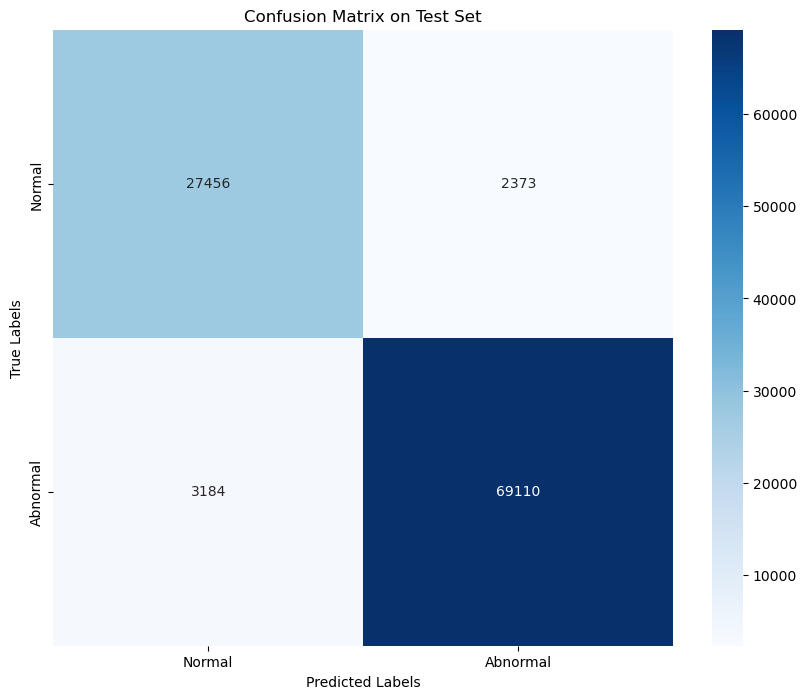

In [35]:
model.eval()
predictions = []
test_labels_all = []

outputs = []
with torch.no_grad():
    for test_naive_inputs, test_cnn_inputs, test_labels in test_loader:

        output = model(test_naive_inputs.to(device), test_cnn_inputs.to(device))
        _, pred_i = torch.max(output, 1)
        predictions.append(pred_i.detach().cpu().numpy())
        test_labels_all.append(test_labels.numpy())
        
        outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    predictions = np.concatenate(predictions, axis=0)
    test_labels_all = np.concatenate(test_labels_all, axis=0)
# Metrics
precision = precision_score(test_labels_all, predictions)
recall = recall_score(test_labels_all, predictions)
f1 = f1_score(test_labels_all, predictions)

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(test_labels_all, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

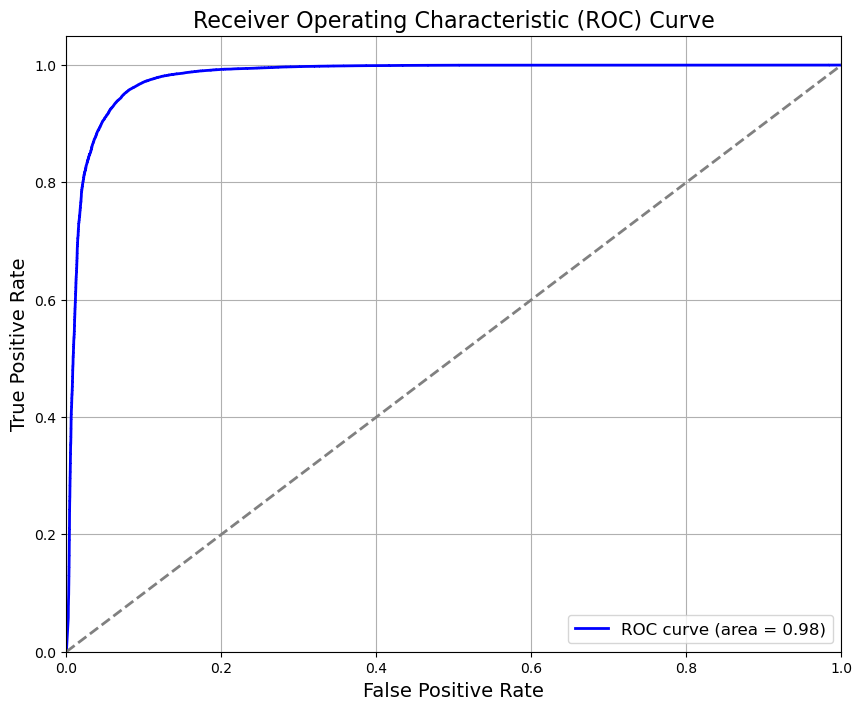

In [34]:
# ROC Curve and AUC
probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(test_labels_all, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(test_labels_all, probabilities)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.savefig('roc.png')
plt.show()